<a href="https://colab.research.google.com/github/d-maniatakos/vaccine-sentiment-classifier/blob/master/vaccine_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Modules Import**

In [86]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve

from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns

import statistics

## **Data Import**

In [144]:
# read datasets and ignore the first (index) column
train_data =  pd.read_csv('vaccine_train_set.csv').iloc[:, 1:]
validation_data = pd.read_csv('vaccine_validation_set.csv').iloc[:, 1:]

## **Data Exploration**

### **Check for Null Values**

In [146]:
train_data.isnull().sum()

tweet    0
label    0
dtype: int64

There are no null values neither in tweet column nor in the label column.

### **Number of Neutral/Positive/Negative Tweets**

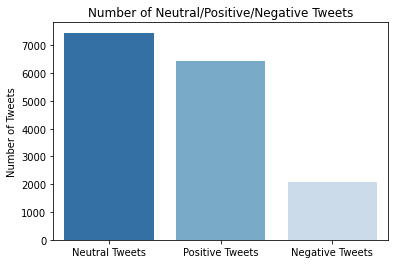

In [147]:
sns.barplot(x=['Neutral Tweets','Positive Tweets','Negative Tweets'], y=train_data['label'].value_counts(), palette='Blues_r').set(title='Number of Neutral/Positive/Negative Tweets', ylabel='Number of Tweets')
plt.show()

It's clear that most tweets in the training dataset express a neutral opinion on vaccines, a little less tweets express a positive opinion and the least tweets express a negative one. There's certainly an imbalance we should consider.

### **Number of N-Grams in Neutral/Negative/Positive Tweets**

In [143]:
def most_used_ngrams(corpus, max_features=15, ngrams=(2, 3), title=''):
  plt.figure(figsize=(min(max_features, 30),3), dpi=200)
  plt.title(title)
  plt.xticks(rotation=45)
  vectorizer = CountVectorizer(ngram_range=ngrams,  max_features=max_features, stop_words='english')
  ngrams = vectorizer.fit_transform(corpus)
  count_sum = ngrams.toarray().sum(axis=0)

  ngram_series = pd.Series(data=count_sum, index=vectorizer.get_feature_names_out()).sort_values(ascending=False)

  sn.barplot(x=ngram_series.index, y=ngram_series.values, palette='Blues_r')


neutral_tweets = train_data[train_data.label == 0]['tweet'].values
negative_tweets = train_data[train_data.label == 1]['tweet'].values
positive_tweets = train_data[train_data.label == 2]['tweet'].values

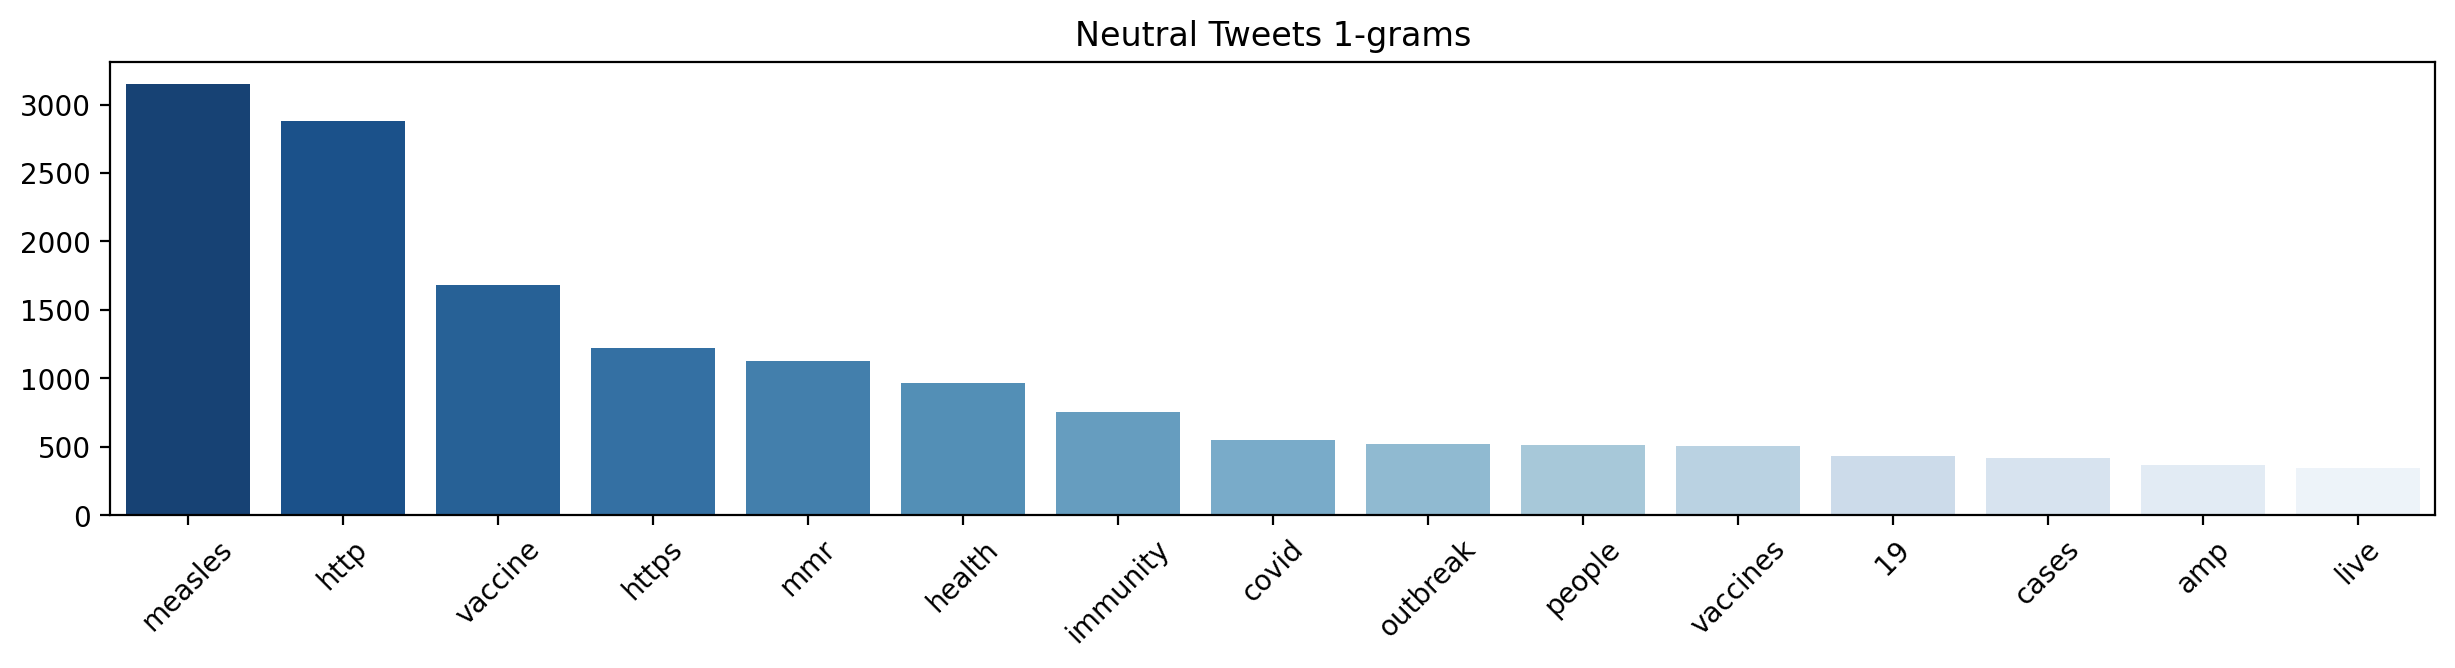

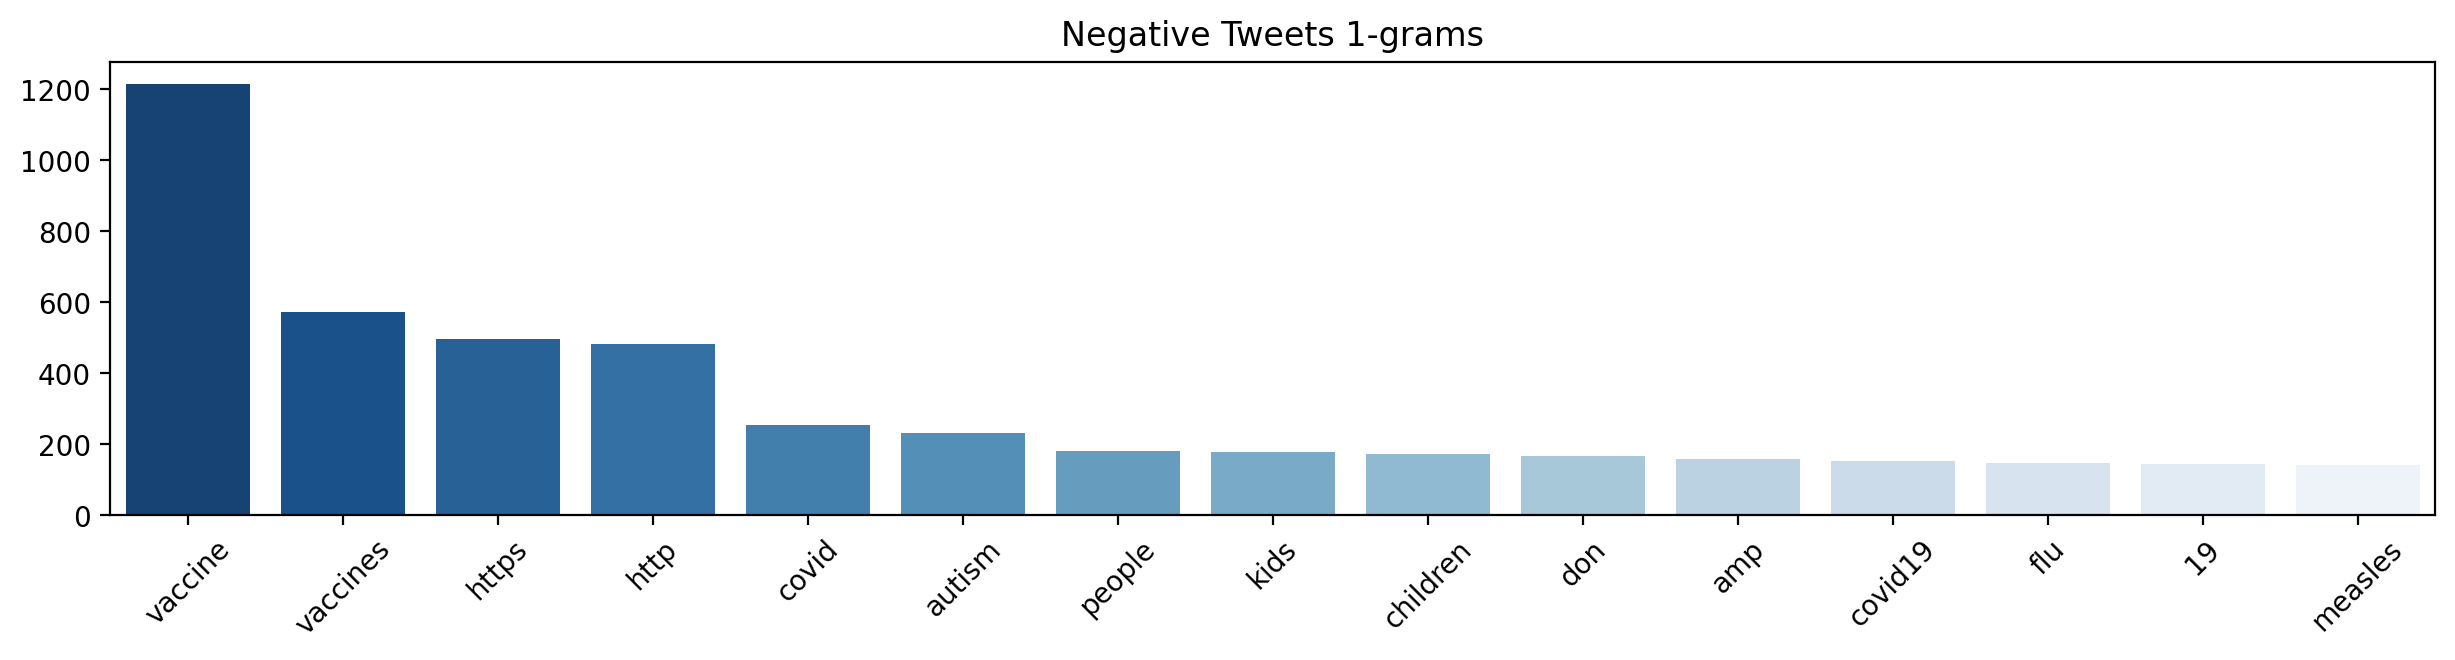

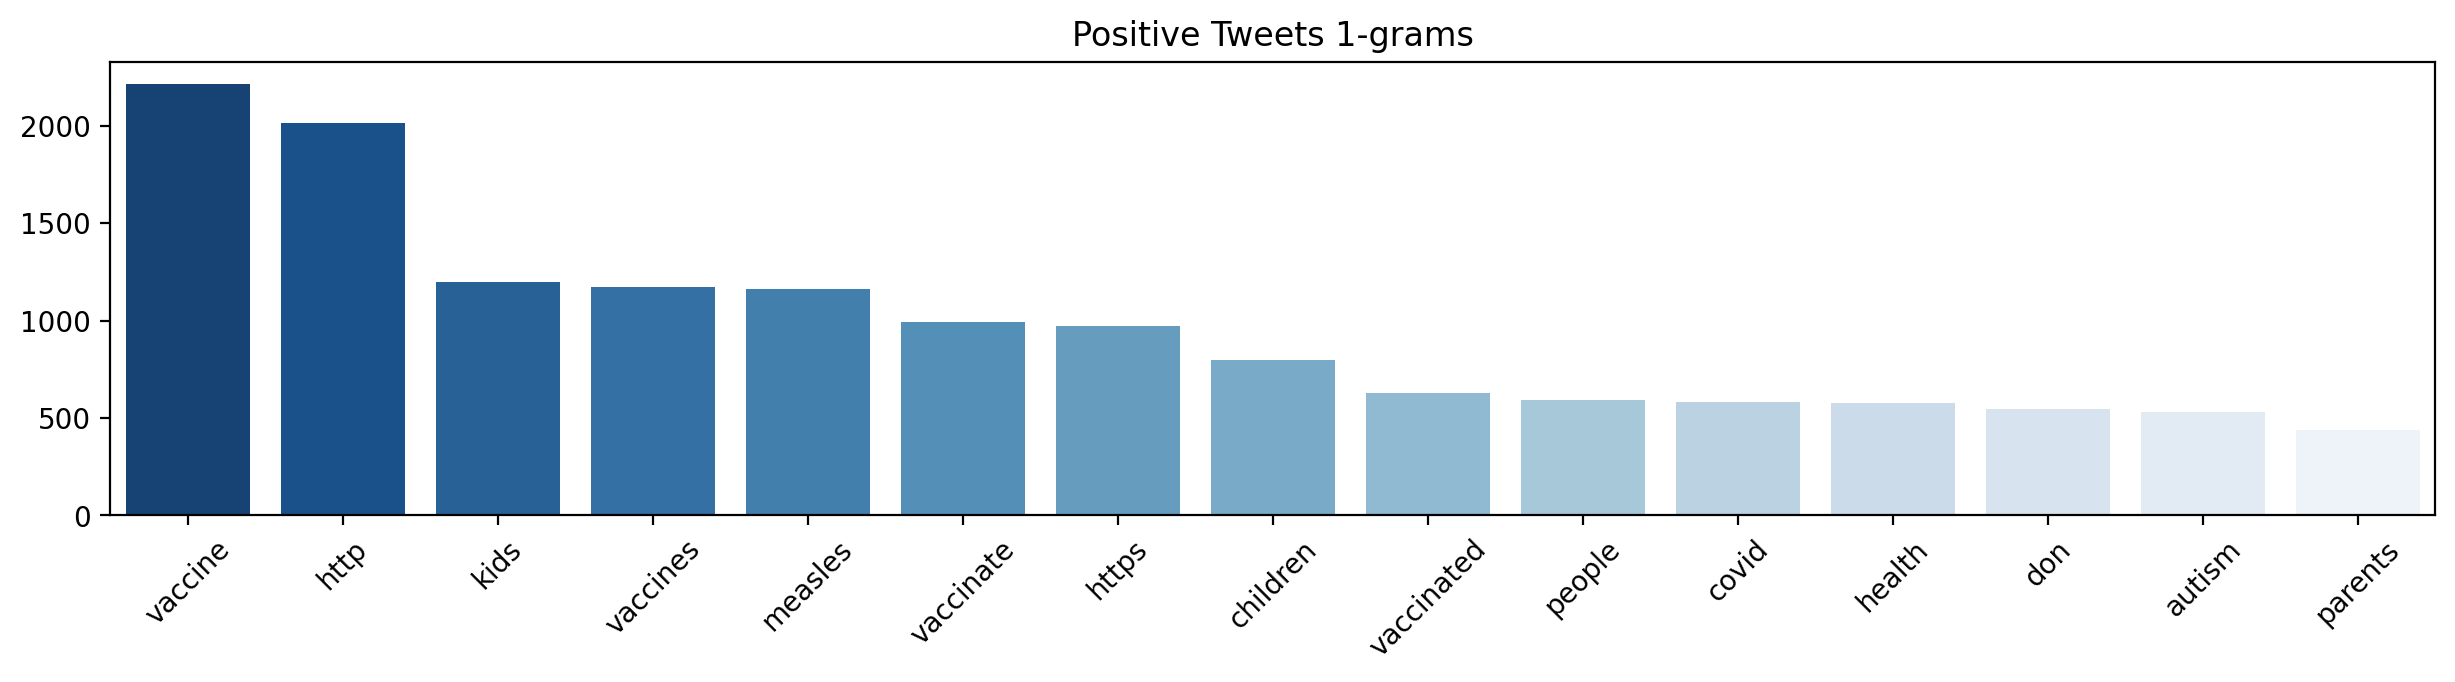

In [68]:
most_used_ngrams(neutral_tweets, title='Neutral Tweets 1-grams', ngrams=(1, 1))
most_used_ngrams(negative_tweets, title='Negative Tweets 1-grams', ngrams=(1, 1))
most_used_ngrams(positive_tweets, title='Positive Tweets 1-grams', ngrams=(1, 1))

All categories of tweets share same words more or less, making it hard to tell them apart just by 1-grams. Let's try bigrams!

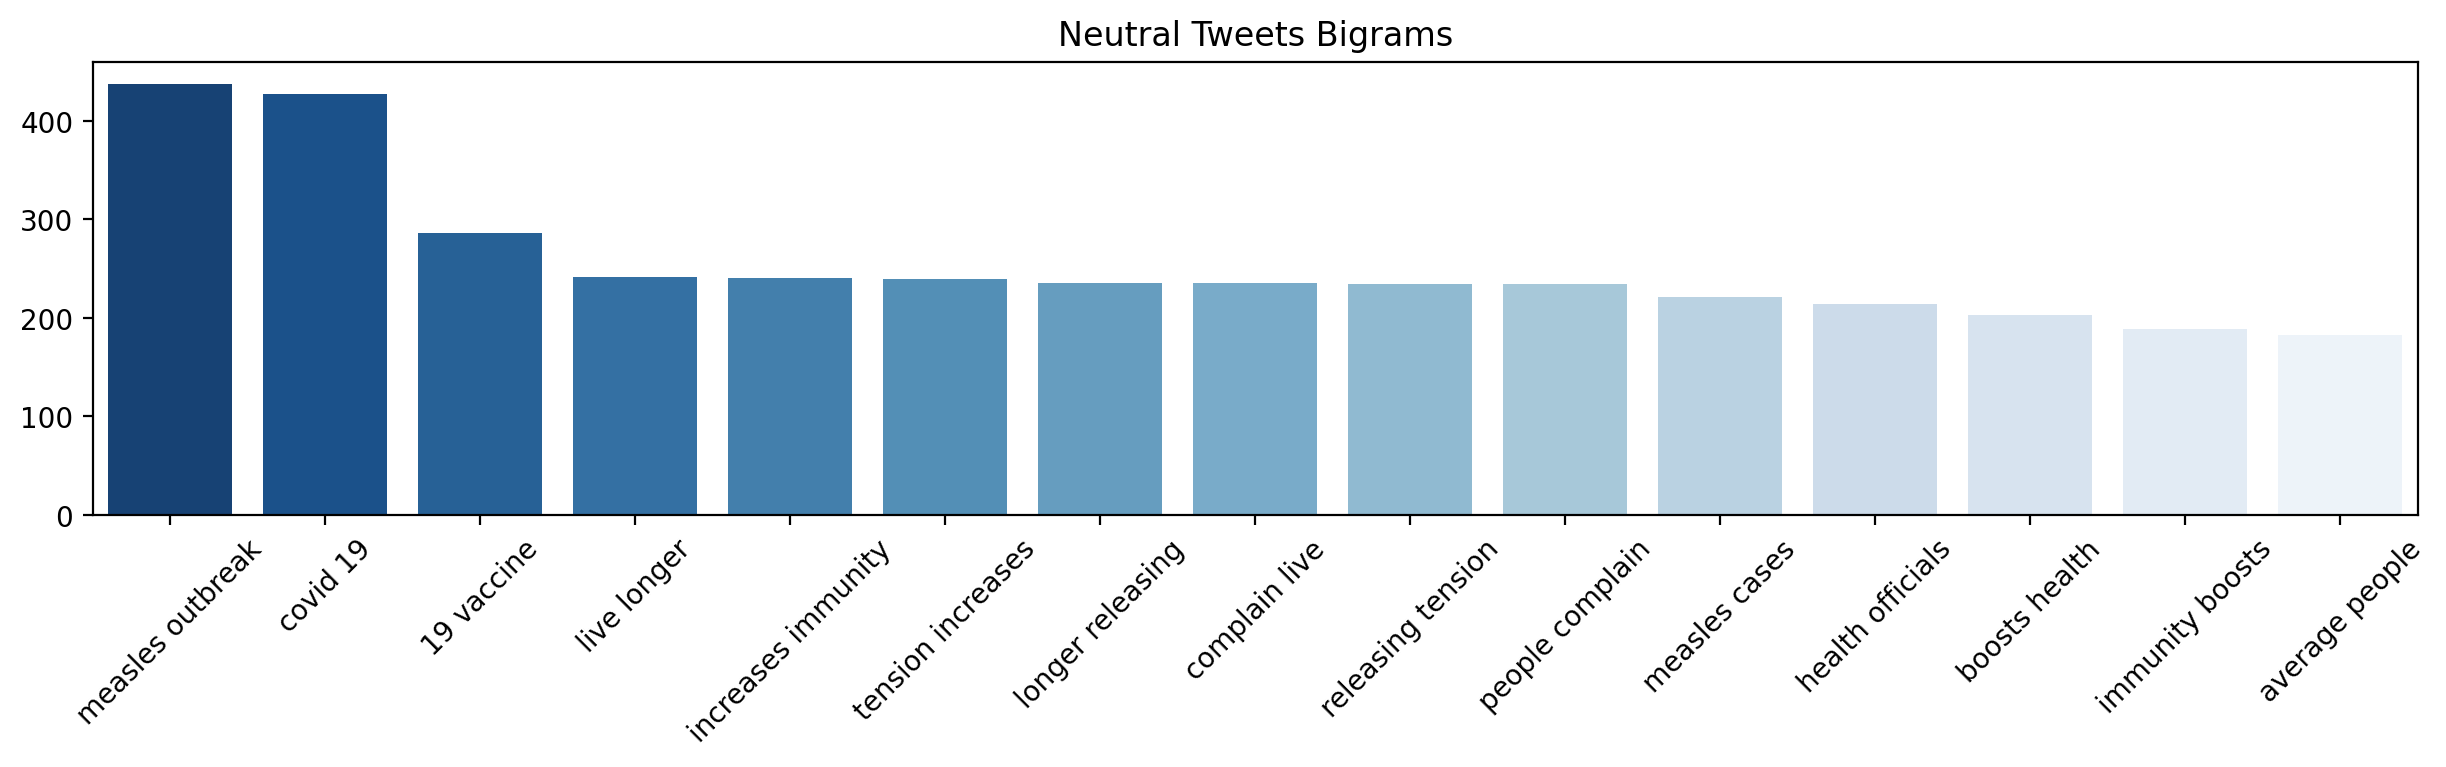

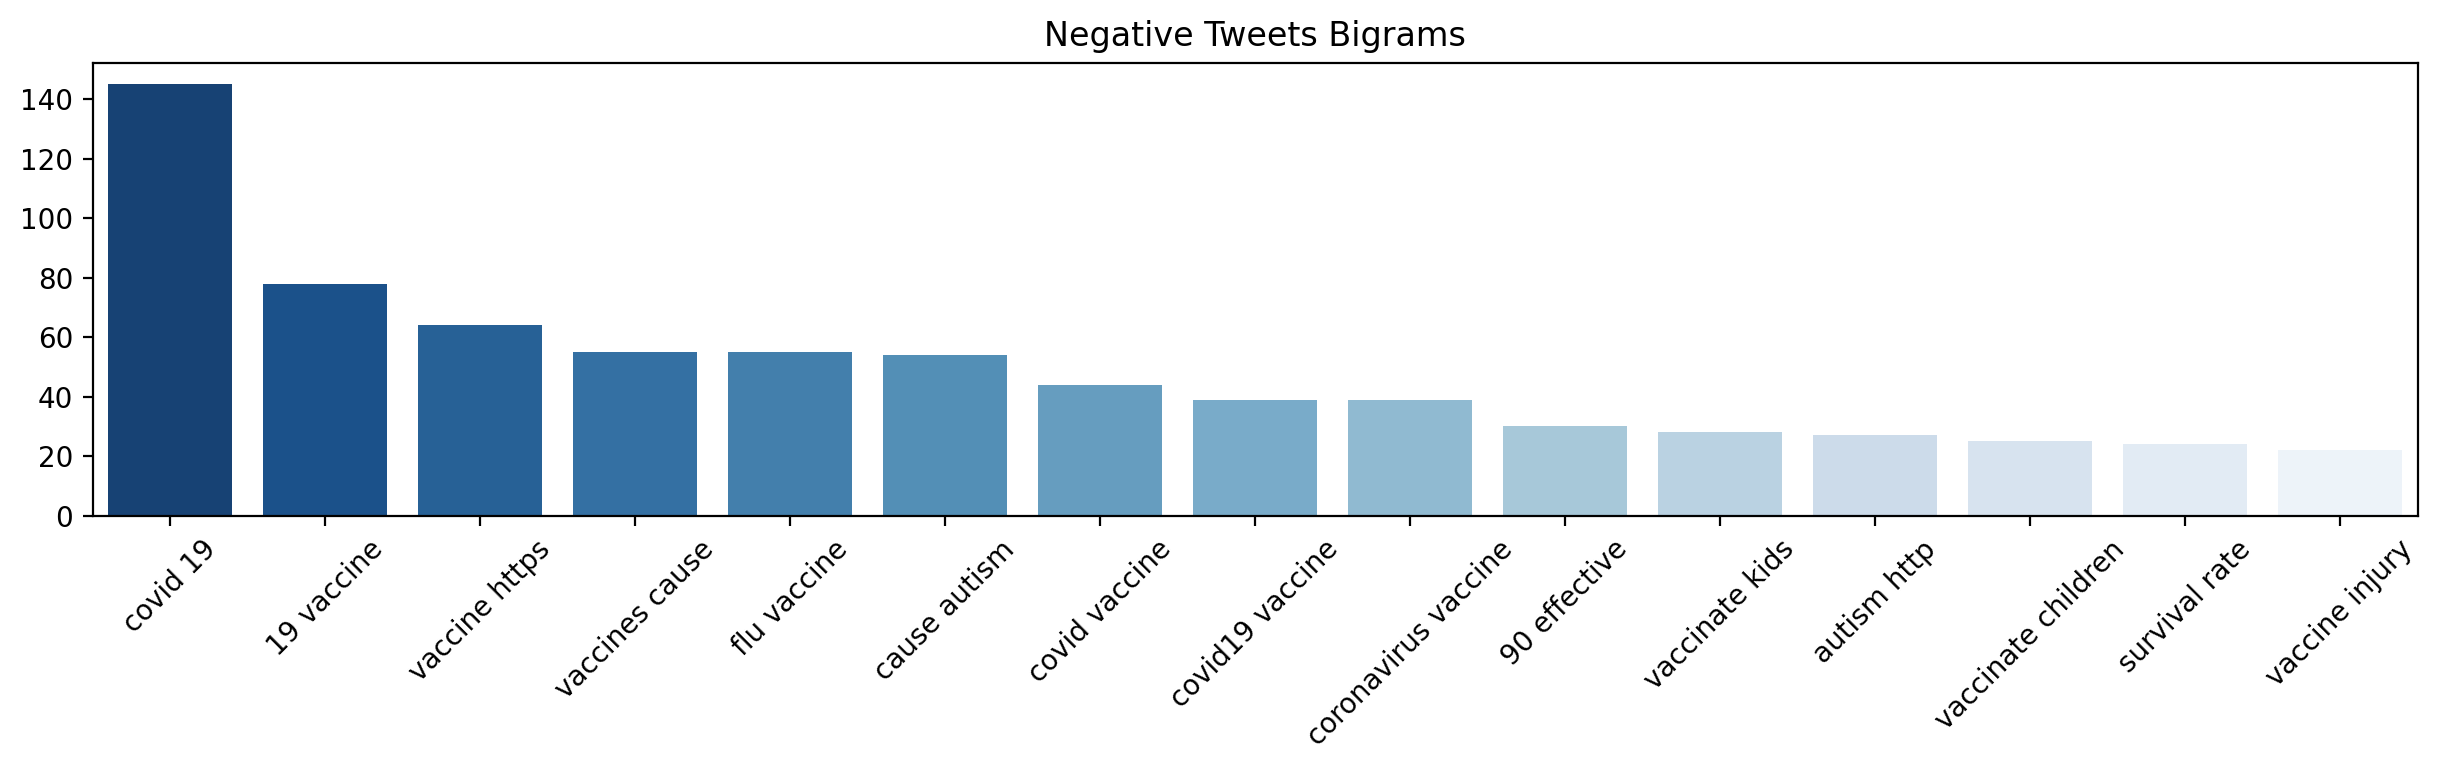

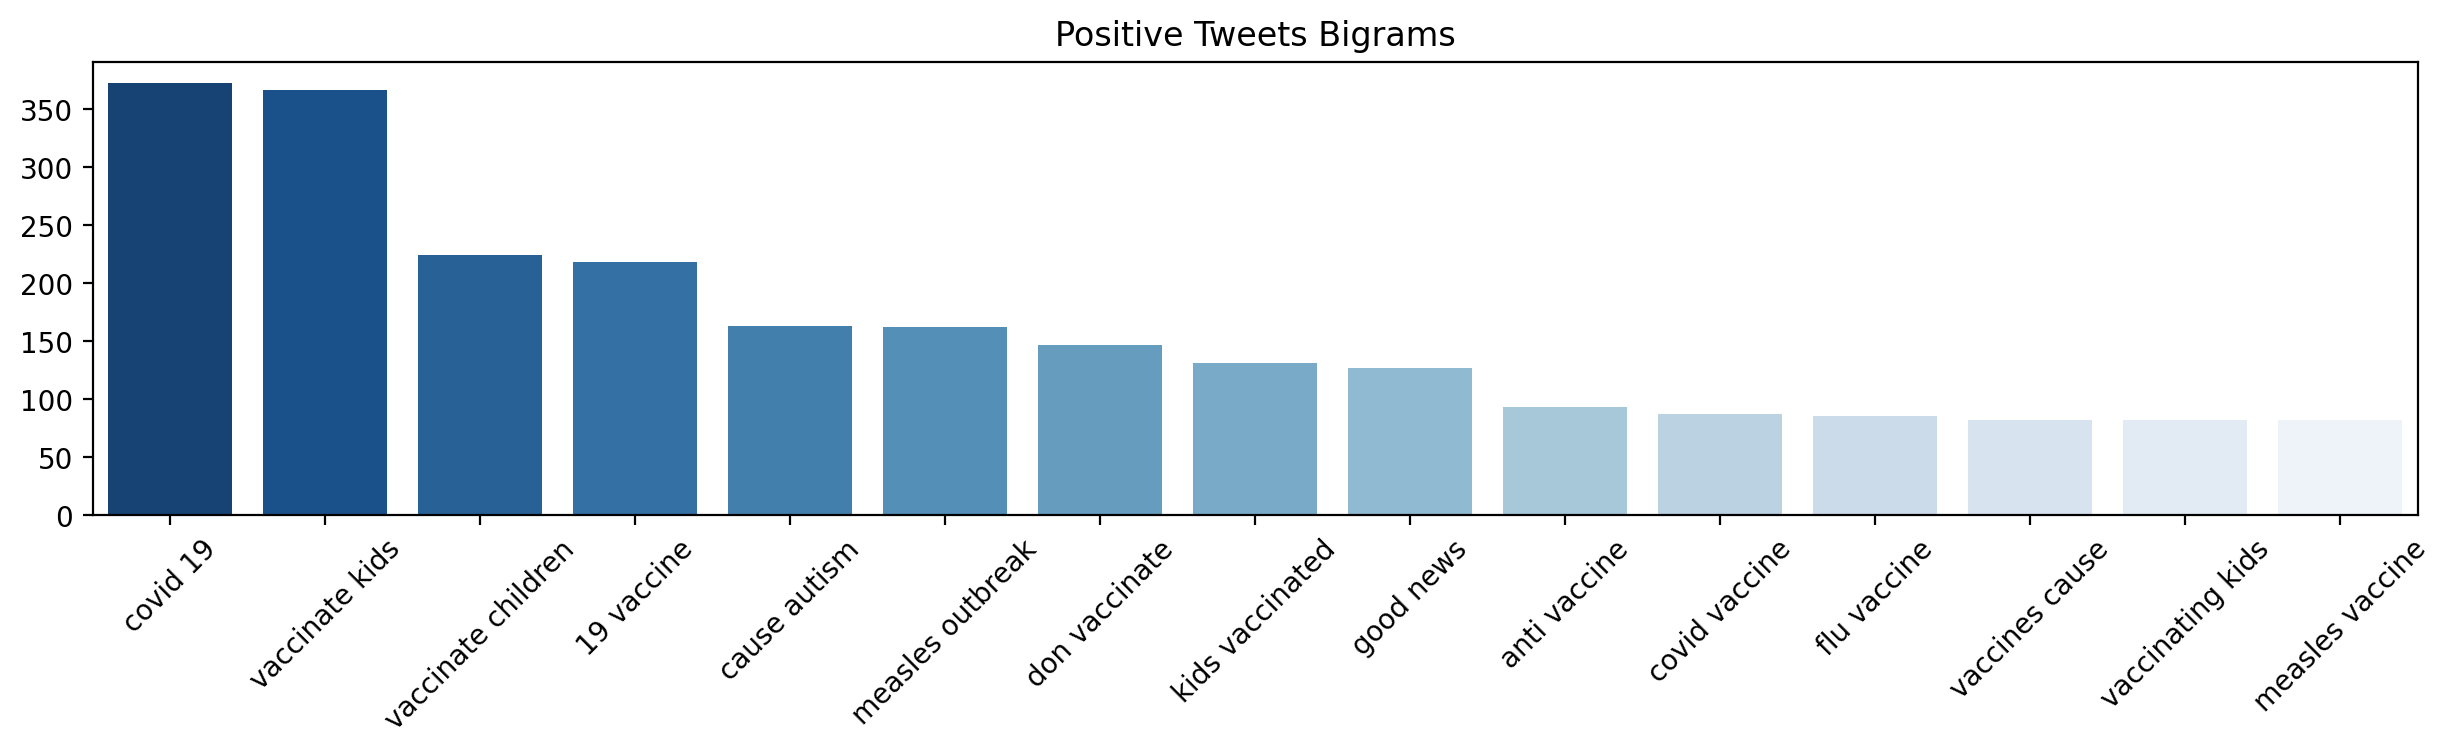

In [69]:
most_used_ngrams(neutral_tweets, title='Neutral Tweets Bigrams', ngrams=(2, 2))
most_used_ngrams(negative_tweets, title='Negative Tweets Bigrams', ngrams=(2, 2))
most_used_ngrams(positive_tweets, title='Positive Tweets Bigrams', ngrams=(2, 2))

While tweets from all three classes share many bigrams/phrases, it's clear that the neutral tweets have a more even distribution of bigrams. Negative tweets tend to use a lot of phrases mentioning autism (possible as an hypothetical side effect of vaccines). Such phrases are also used in positive tweets too. Let's see why this happens...

In [149]:
#print positive tweets which contain phrase "cause autism"
for tweet in positive_tweets.tolist():
  if 'cause autism' in tweet:
    print(tweet)
    

"But I also believe vaccines cause autism and have probably caused the deaths of dozens of children by spreading it" http://t.co/YflmFFoJuY
@AC360 and if people think vaccinations can cause autism would they rather have an autistic child or a dead child?
“@Gen_Ironicus: Dr. Oz is on tv spotlighting claims that vaccines cause autism. Reminder that everyone named Oz is a fraud.” @ozkangaroo D:&gt;
If vaccines don't cause autism, what's stopping you from faking autism and winning millions in vaccine court like others? y r u still poor?
People say that vaccines cause autism because autism has increased along with our use of vaccines. THAT DOESNT MEAN ANYTHING.
“@simonsmart23: @BarrowMillHouse @RobSchneider  not vaccinated my kids" not your fault vaccines do not cause autism http://t.co/T2evhWZJ9c
@lorabruncke @ScienceBasedRD @graceonline @MicheleRSimon lemme guess, vaccines cause autism and chemtrails make us sick, too?
Vaccines don't cause autism, #2048 does.
it was disproven DECADES ago 

It's clear that these tweets are indeed by people who are positive to the vaccines who try to debunk arguments against vaccines, made by anti-vaccinists. It's probable that this will make classification even harder.

### **Median Length of Neutral/Negative/Positive**

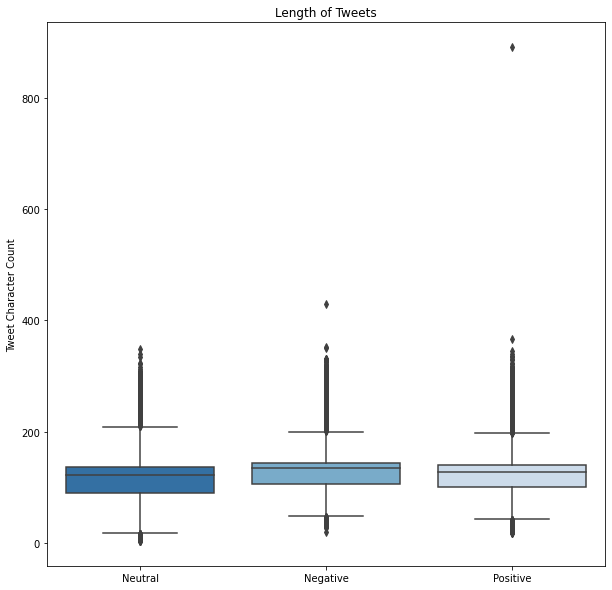

In [140]:
train_data_copy = train_data.copy()
train_data_copy['Tweet Character Count'] = train_data_copy['tweet'].str.len()
train_data_copy['label'] = train_data_copy['label'].map({0:'Neutral', 1:'Negative', 2:'Positive'})

plt.figure(figsize=(10, 10))
sns.boxplot(x="label", y="Tweet Character Count", data=train_data_copy, palette='Blues_r').set(title='Length of Tweets')
plt.xlabel('')
plt.show()

The negative tweets tend to be slightly longer while neutral tweets tend to be slightly shorter, but the difference is not that big to justify using it as a seperate feature in our model.

## **Preprocessing & Vectorization**

In [152]:
def preprocess(text):
  text = text.replace('@', '')
  text = text.replace('#', '')

  return text

def create_vectorizer(train_corpus, method='tf-idf', max_features=20000, ngram_range=(1, 4)):
  if method == 'tf-idf':
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
  elif method == 'bow':
    vectorizer = CountVectorizer(max_features=max_features, ngram_range=ngram_range)
  return vectorizer.fit(train_corpus)

def vectorize(vectorizer, corpus):
  return vectorizer.transform(corpus)

train_data['tweet'] = train_data['tweet'].apply(preprocess)
validation_data['tweet'] = validation_data['tweet'].apply(preprocess)

train_corpus = train_data['tweet'].tolist()
validation_corpus = validation_data['tweet'].tolist()


vectorizer = create_vectorizer(train_corpus)
train_vector = vectorize(vectorizer, train_corpus)
validation_vector = vectorize(vectorizer, validation_corpus)

x_train = train_vector.toarray()
y_train = train_data['label'].values

x_validation = validation_vector.toarray()
y_validation = validation_data['label'].values

## **Model Creation, Training & Evaluation**

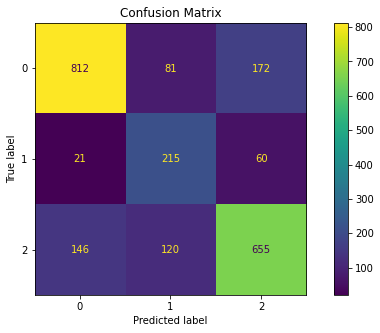

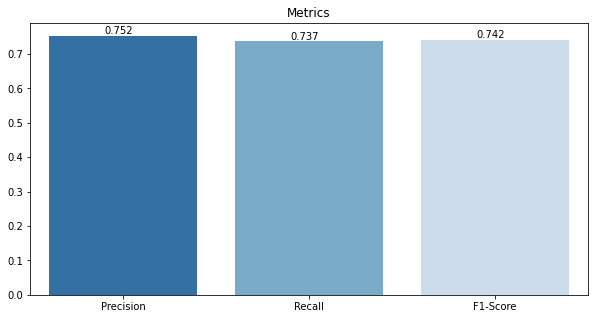

Precision: 0.7521550395803012
Recall: 0.7370727432077125
F1-Score: 0.7415626233048073


In [153]:
classifier = LogisticRegression(multi_class="multinomial", max_iter=1000, class_weight='balanced')
classifier.fit(x_train, y_train)

y_predicted_validation = classifier.predict(x_validation)
precision = precision_score(y_validation, y_predicted_validation, average='weighted')
recall = recall_score(y_validation, y_predicted_validation, average='weighted')
f1 = f1_score(y_validation, y_predicted_validation, average='weighted')

# train_sizes, train_scores, test_scores= learning_curve(classifier, x_train, y_train, cv=4)

plt.figure(figsize=(10, 5))
plt.grid(True)
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.plot(train_sizes,np.mean(train_scores,axis=1),  "o-")
plt.plot(train_sizes,np.mean(test_scores,axis=1),  "o-")
plt.legend(['Training Score', 'Validation Score'])
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
plt.title('Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(classifier, x_validation, y_validation, ax=ax)
plt.show()


plt.figure(figsize=(10, 5))
plt.title('Metrics')
sn.barplot(x=['Precision', 'Recall', 'F1-Score'], y=[precision, recall, f1], palette='Blues_r')
for index, value in enumerate([precision, recall, f1]):
    plt.text(index-0.1, value+0.005,str(round(value,3)))
plt.show()
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1-Score: ' + str(f1))

## **Predictions**

In [160]:
def predict_sentiment(text):
  text = preprocess(text)
  text_vector = vectorize(vectorizer, [text])
  prediction = classifier.predict(text_vector)
  if prediction[0] == 0:
    print('Neutral Sentiment')
  elif prediction[0] == 1:
    print('Negative Sentiment')
  elif prediction[0] == 2:
    print('Positive Sentiment')

predict_sentiment("Vaccines kill people")
predict_sentiment("I am in favour of vaccines, I believe they will help fight coronavirus")
predict_sentiment("Why cannot we just listen to what the scientists say?")
predict_sentiment("I hate anti-vaccinists")
predict_sentiment("Vaccines are fake")

Negative Sentiment
Positive Sentiment
Positive Sentiment
Positive Sentiment
Negative Sentiment
